# Fake news and True news classifier
Credits for the sklearn code: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [350]:
# Load the train data
import json
import pandas as pd
with open("data/real_train.json", "r", encoding="utf8") as file:
    real_train = pd.read_json(file)

with open("data/fake_train.json", "r", encoding="utf8") as file:
    fake_train = pd.read_json(file)

# Inspect the data
print(len(real_train))
print(len(fake_train))

#print(real_train.head())
#print(fake_train.head())

# Add index
# 0 = True, 1 = Fake
real_train["target"] = 0
fake_train["target"] = 1

# Load the test data
with open("data/real_test.json", "r", encoding="utf8") as file:
    real_test = pd.read_json(file)

with open("data/fake_test.json", "r", encoding="utf8") as file:
    fake_test = pd.read_json(file)
    
# 0 = True, 1 = Fake
real_test["target"] = 0
fake_test["target"] = 1

print(len(fake_test))

800
800
200


In [304]:
# Drop duplicates in case there are any
real_train = real_train.drop_duplicates(subset ="text")
fake_train = fake_train.drop_duplicates(subset ="text")
real_test = real_test.drop_duplicates(subset ="text")
fake_test = fake_test.drop_duplicates(subset ="text")

In [305]:
#Check the average length of real news vs fake news in the dataset
print("Real len train: ", np.mean([len(line) for line in real_train.text]))
print("Fake len train: ", np.mean([len(line) for line in fake_train.text]))
print("Real len test: ", np.mean([len(line) for line in real_test.text]))
print("Fake len test: ", np.mean([len(line) for line in fake_test.text]))

Real len train:  3546.125
Fake len train:  3492.050615595075
Real len test:  3386.2323232323233
Fake len test:  2917.4114583333335


## Inspect the data

In [306]:
# Inspect the text line by line for a few samples to get a sense of the data
fake_train.text[4] #Found a line that starts with Fatal error
real_train.text[100] #Found something that looks like: ({{contentCtrl.commentsTotal}})

'Conscript in Kalev Infantry Battalion diagnosed with coronavirus ({{contentCtrl.commentsTotal}})\nA conscript in the Kalev Infantry Battalion (Kalevi jalaväepataljoni) was diagnosed with the COVID-19 virus on Friday after attending a volleyball match in Saaremaa at the weekend where an outbreak of the coronavirus has been detected.\nThe conscript returned to the army on Sunday. On Monday night, he began to experience health problems. On Tuesday morning, he went to the infirmary and was tested for the COVID-19 virus and isolated.\nOn Friday, the laboratory confirmed the sample as positive. Following the announcement, 146 conscripts and eight active soldiers were quarantined. Other units are not in quarantine.\nThe military doctor said, currently, there are no more symptomatic cases.\nMilitary and active military personnel will remain in quarantine for two weeks. They will receive food in heated vacuum flasks from the canteen which will be left behind the doors to their rooms. Empty fla

In [307]:
# Check for Fatal error
import re

for line in list(fake_train.text):
    if re.findall("Fatal error:", line):
        print(line)
        
# Check for ({{contentCtrl
for line in list(real_train.text):
    if re.findall("({{contentCtrl.commentsTotal}})", line):
        print("------------")
        print(line)

Fatal error: Uncaught MongoDB\Driver\Exception\ConnectionTimeoutException: No suitable servers found (`serverSelectionTryOnce` set): [connection refused calling ismaster on '127.0.0.1:27017'] in /var/www/html/kachaf/php/vendor/mongodb/mongodb/src/Collection.php:645
Stack trace:
#0 /var/www/html/kachaf/php/vendor/mongodb/mongodb/src/Collection.php(645): MongoDB\Driver\Manager->selectServer(Object(MongoDB\Driver\ReadPreference))
#1 /var/www/html/kachaf/php/scripts/getter.php(105): MongoDB\Collection->findOne(Array)
#2 /var/www/html/kachaf/public/details.php(10): getter->findbyid('5e8957fe1cd0fa0...', 'news')
#3 {main}
thrown in/var/www/html/kachaf/php/vendor/mongodb/mongodb/src/Collection.phpon line645
Fatal error: Uncaught MongoDB\Driver\Exception\ConnectionTimeoutException: No suitable servers found (`serverSelectionTryOnce` set): [connection refused calling ismaster on '127.0.0.1:27017'] in /var/www/html/kachaf/php/vendor/mongodb/mongodb/src/Collection.php:645
Stack trace:
#0 /var/www

From inspecting the data:
1. Remove ({{contentCtrl.commentsTotal}}) from real_train
2. Remove "Fatal error" from fake_train

Note: Removing the lines that have Fatal error means that I'm reducing the amount of data. But if real data has the comments element and fake data has the Fatal error in it, the classifier will have an easy time classifying - but for an arbitrary reason. Thus both need to be removed, even if it means having less data.

## Composing the classifier
1. Make a classifier with keeping the original data as it is
2. Classifier where contentCtrl and Fatal error is removed
3. Classifier where the text is additionally lower-cased and punctuation is removed

For simplicity I will put the 1st and 2nd classifiers as appendix and focus on 3rd.

Generally: report the results for 2 classifiers originally, compose a confusion matrix. Later try out more classifiers.

### Classifier: remove contentCtrl and Fatal error, normalize text

In [308]:
# Remove contentCtrl from real_train
import re
real_train['text'] = real_train['text'].str.replace(r'\({{contentCtrl.commentsTotal}}\)', '')
real_test['text'] = real_test['text'].str.replace(r'\({{contentCtrl.commentsTotal}}\)', '')

# Remove lines that have Fatal error
fake_train = fake_train[~fake_train.text.str.startswith('Fatal error:')]
fake_test = fake_test[~fake_test.text.str.startswith('Fatal error:')]

# Normalize text - remove punctuation and lowercase everything
fake_train["text_pun"] = fake_train['text'].str.replace('[^\w\s]',' ')
fake_train["text_pun"] = fake_train["text_pun"].str.lower()

fake_test["text_pun"] = fake_test['text'].str.replace('[^\w\s]',' ')
fake_test["text_pun"] = fake_test["text_pun"].str.lower()

real_train["text_pun"] = real_train['text'].str.replace('[^\w\s]',' ')
real_train["text_pun"] = real_train["text_pun"].str.lower()

real_test["text_pun"] = real_test['text'].str.replace('[^\w\s]',' ')
real_test["text_pun"] = real_test["text_pun"].str.lower()

In [309]:
#Check the average length of real news vs fake news in the dataset
print("Real len train: ", np.mean([len(line) for line in real_train.text_pun]))
print("Fake len train: ", np.mean([len(line) for line in fake_train.text_pun]))
print("Real len test: ", np.mean([len(line) for line in real_test.text_pun]))
print("Fake len test: ", np.mean([len(line) for line in fake_test.text_pun]))

# Check for length of datasets
print("Real train: ", len(real_train.text_pun))
print("Fake train: ", len(fake_train.text_pun))
print("Real test: ", len(real_test.text_pun))
print("Fake test: ", len(fake_test.text_pun))

Real len train:  3543.82421875
Fake len train:  3507.365887207703
Real len test:  3384.510101010101
Fake len test:  2940.657894736842
Real train:  768
Fake train:  727
Real test:  198
Fake test:  190


In [310]:
len(real_train) - len(fake_train)

41

There is a large difference between the lengths of real and fake train dataset. I will remove data from real train to make them equal with attempting to keep the balance between the news lengths in the two classes.

In [311]:
real_train = real_train[0:727]

print("Real len train: ", np.mean([len(line) for line in real_train.text_pun]))
print("Fake len train: ", np.mean([len(line) for line in fake_train.text_pun]))

print("Real train: ", len(real_train.text_pun))
print("Fake train: ", len(fake_train.text_pun))

Real len train:  3518.338376891334
Fake len train:  3507.365887207703
Real train:  727
Fake train:  727


The difference between fake and real test dataset lengths per news is much bigger than the difference in tha training dataset. Also, the cleaning threw away some data for the test dataset of fake news. I'll exclude the longest 2 news in the test set for real news to both help with the balance of the test datasets and to reduce the error that the classifier will do well because it's predicting news based on the news length.

In [312]:
# Remove two longest news in real_test
print(real_test.text.map(lambda x: len(x)).max())
real_test = real_test[real_test['text_pun'].apply(lambda x: len(x) != real_test.text_pun.map(lambda x: len(x)).max())]
print(real_test.text.map(lambda x: len(x)).max())
real_test = real_test[real_test['text_pun'].apply(lambda x: len(x) != real_test.text_pun.map(lambda x: len(x)).max())]
print(real_test.text.map(lambda x: len(x)).max())
real_test = real_test[real_test['text_pun'].apply(lambda x: len(x) != real_test.text_pun.map(lambda x: len(x)).max())]
print(real_test.text.map(lambda x: len(x)).max())
real_test = real_test[real_test['text_pun'].apply(lambda x: len(x) != real_test.text_pun.map(lambda x: len(x)).max())]
print(real_test.text.map(lambda x: len(x)).max())
real_test = real_test[real_test['text_pun'].apply(lambda x: len(x) != real_test.text_pun.map(lambda x: len(x)).max())]

# Check what's the new averages
print("Real len test: ", np.mean([len(line) for line in real_test.text_pun]))
print("Fake len test: ", np.mean([len(line) for line in fake_test.text_pun]))

# Check the lengths of the dataframes
print("Real test: ", len(real_test.text_pun))
print("Fake test: ", len(fake_test.text_pun))

27829
19947
18202
18167
14966
Real len test:  2958.663212435233
Fake len test:  2940.657894736842
Real test:  193
Fake test:  190


In [313]:
# Since there is a balance now
real_test = real_test[0:190]

print("Real len test: ", np.mean([len(line) for line in real_test.text_pun]))
print("Fake len test: ", np.mean([len(line) for line in fake_test.text_pun]))

print("Real test: ", len(real_test.text_pun))
print("Fake test: ", len(fake_test.text_pun))

Real len test:  2963.278947368421
Fake len test:  2940.657894736842
Real test:  190
Fake test:  190


Now the datasets are better balanced in how long the news are for all groups and the length of the datasets are the same again.

In [314]:
# Join data together for real and fake news
df_train = pd.concat([real_train, fake_train])
df_test = pd.concat([real_test, fake_test])

In [315]:
# Classifier with Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.text_pun)
X_train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, df_train.target)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(df_train.text_pun, df_train.target)

import numpy as np
predicted = text_clf.predict(df_test.text_pun)
np.mean(predicted == df_test.target)

0.9631578947368421

Confusion Matrix : 
 [[188   2]
 [ 12 178]]
Accuracy :  0.9631578947368421
Sensitivity :  0.9894736842105263
Specificity :  0.9368421052631579


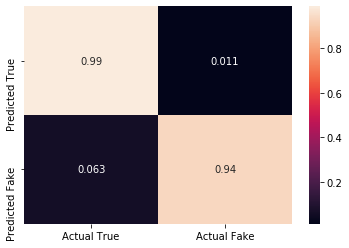

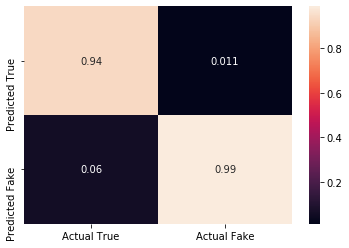

In [316]:
# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted

C = confusion_matrix(y_true, y_pred)
print('Confusion Matrix : \n', C)

total1=sum(sum(C))

accuracy1=(C[0,0]+C[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = C[0,0]/(C[0,0]+C[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = C[1,1]/(C[1,0]+C[1,1])
print('Specificity : ', specificity1)

# Normalize confusion matrix along actual values
B = C / C.astype(np.float).sum(axis=1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = B
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Normalize confusion matrix along predicted values
A = C / C.astype(np.float).sum(axis=0)

array = A
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [342]:
# Classifier as SVM
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42)),]) #n_iter=5
_ = text_clf_svm.fit(df_train.text_pun, df_train.target)
predicted_svm = text_clf_svm.predict(df_test.text_pun)
np.mean(predicted_svm == df_test.target)

0.9789473684210527

Confusion Matrix : 
 [[187   3]
 [  5 185]]
Accuracy :  0.9789473684210527
Sensitivity :  0.9842105263157894
Specificity :  0.9736842105263158


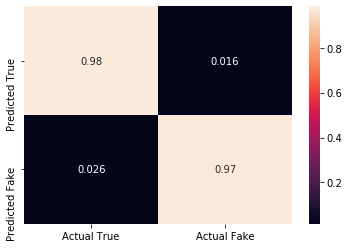

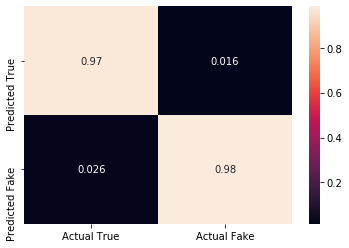

In [343]:
# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted_svm

C2 = confusion_matrix(y_true, y_pred)
print('Confusion Matrix : \n', C2)

total2=sum(sum(C2))

accuracy2=(C2[0,0]+C2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = C2[0,0]/(C2[0,0]+C2[0,1])
print('Sensitivity : ', sensitivity2 )

specificity2 = C2[1,1]/(C2[1,0]+C2[1,1])
print('Specificity : ', specificity2)

# Normalize confusion matrix along actual values
B = C2 / C2.astype(np.float).sum(axis=1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = B
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Normalize confusion matrix along predicted values
A = C2 / C2.astype(np.float).sum(axis=0)

array = A
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Ideally what we want is to have is both high sensitivity and specificity. Plotting the two classifiers results together:

In [319]:
print('NB Confusion Matrix : \n', C)
print ('Accuracy : ', accuracy1)
print('Sensitivity : ', sensitivity1)
print('Specificity : ', specificity1)

NB Confusion Matrix : 
 [[188   2]
 [ 12 178]]
Accuracy :  0.9631578947368421
Sensitivity :  0.9894736842105263
Specificity :  0.9368421052631579


In [320]:
print('SVM Confusion Matrix : \n', C2)
print ('Accuracy : ', accuracy2)
print('Sensitivity : ', sensitivity2)
print('Specificity : ', specificity2)

SVM Confusion Matrix : 
 [[187   3]
 [  5 185]]
Accuracy :  0.9789473684210527
Sensitivity :  0.9842105263157894
Specificity :  0.9736842105263158


Here we see that SVM has a slightly lower sensitivity but a higher specificity and accuracy compared to NB. If I'd have to choose which error rate to optimize towards, I'd rather have more real news predicted as fake than to have fake news predicted as true. From this aspect I'd prefer SVM since it classifies 5 fake news as real and 3 real news as fake. Five is still a lot, I'll see if I can get better results with optimized parameters.

### Now to optimize some of the parameters to see if that makes a difference

In [321]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train.text_pun, df_train.target)

In [322]:
# Print the best parameters
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.9656120393411541
{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [323]:
# Same for SVM classifier
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(df_train.text_pun, df_train.target)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.975231662519256
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [324]:
# Run NB again with improved parameters
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.text_pun)
X_train_counts.shape

# Define the new parameters
params_nb = gs_clf.best_params_

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

from sklearn.naive_bayes import MultinomialNB
# Run with new parameters
#clf = MultinomialNB()
#clf = clf.set_params(**params_nb)
#clf = clf.fit(X_train_tfidf, df_train.target)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.set_params(**params_nb)
text_clf = text_clf.fit(df_train.text_pun, df_train.target)

import numpy as np
predicted = text_clf.predict(df_test.text_pun)
np.mean(predicted == df_test.target)

0.9763157894736842

In [325]:
# This is better than the previous score so I'll run the updated confusion matrix
# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted

C = confusion_matrix(y_true, y_pred)
total1=sum(sum(C))
accuracy1=(C[0,0]+C[1,1])/total1
sensitivity1 = C[0,0]/(C[0,0]+C[0,1])
specificity1 = C[1,1]/(C[1,0]+C[1,1])

In [326]:
# Run SVM again with improved parameters
# Classifier as SVM
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42)),]) #n_iter=5
params_svm = gs_clf_svm.best_params_

text_clf_svm = text_clf_svm.set_params(**params_svm)
_ = text_clf_svm.fit(df_train.text_pun, df_train.target)
predicted_svm = text_clf_svm.predict(df_test.text_pun)
np.mean(predicted_svm == df_test.target)

0.9763157894736842

In [327]:
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted_svm

C3 = confusion_matrix(y_true, y_pred)
total3=sum(sum(C3))
accuracy3=(C3[0,0]+C3[1,1])/total3
sensitivity3 = C3[0,0]/(C3[0,0]+C3[0,1])
specificity3 = C3[1,1]/(C3[1,0]+C3[1,1])

In [328]:
print('NB Confusion Matrix : \n', C)
print ('Accuracy : ', accuracy1)
print('Sensitivity : ', sensitivity1)
print('Specificity : ', specificity1)

NB Confusion Matrix : 
 [[189   1]
 [  8 182]]
Accuracy :  0.9763157894736842
Sensitivity :  0.9947368421052631
Specificity :  0.9578947368421052


In [329]:
print('SVM Confusion Matrix : \n', C3)
print ('Accuracy : ', accuracy3)
print('Sensitivity : ', sensitivity3)
print('Specificity : ', specificity3)

SVM Confusion Matrix : 
 [[188   2]
 [  7 183]]
Accuracy :  0.9763157894736842
Sensitivity :  0.9894736842105263
Specificity :  0.9631578947368421


Seems like the best model at hand currently is the original SVM - optimized parameters for some reason brough up the error rate for classifying fake news as real news.

# Conclusions

The non-optimized SVM classifier outperforms NB: 5 fake news are categorized as real news and 3 real news are classified as fake.

Manipulations made to get to this result:
1. Remove duplicates
2. Remove the two most common errors I saw in fake and real datasets
3. Optimize towards similar length of news across all classes in both train and test datasets
4. Balance both datasets

There shouldn't be much error with regards to data leakage. However, I could get better results if I'd use title and URL in the predictions but that would require extra work in terms of potential biases that can come from that (I'd have to check whether the URL that only exists in the training dataset of real news doesn't occur in the test dataset for fake news because those news will then be predicted as true as a default), also it's generally more interesting to analyise the text itself over the URL-s and title's.

To see what's up with the ones that were classified incorrectly, I'll print them below.

In [348]:
print('SVM Confusion Matrix : \n', C2)
print ('Accuracy : ', accuracy2)
print('Sensitivity : ', sensitivity2)
print('Specificity : ', specificity2)

SVM Confusion Matrix : 
 [[187   3]
 [  5 185]]
Accuracy :  0.9789473684210527
Sensitivity :  0.9842105263157894
Specificity :  0.9736842105263158


In [349]:
# Showing the fake news that were classified as real news
reals = predicted_svm[190:]
print(reals)

df = pd.DataFrame(list(zip(reals, df_test.text_pun)), 
               columns =['Predicted', 'text']) 

#Print the incorrect rows
fakes = df[df["Predicted"] == 0].reset_index()

fakes#.text[0]

[1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1]


,index,Predicted,text
0,4,0,new mexico counties rural residents fight tra...
1,6,0,the immune system plays a vital role in protec...
2,52,0,china has reported an increase in the number o...
3,77,0,german carnival floats take aim at racism in w...
4,180,0,half of moscow s coronavirus patients in serio...


# Appendix
1. Predicting results from title only
2. Running the model on just the original data

## 2. Predict class based on title only

0.8955613577023499
[[171  22]
 [ 18 172]]


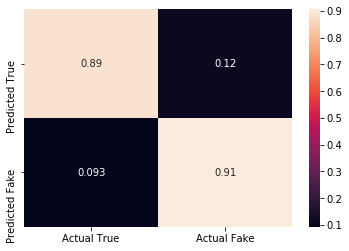

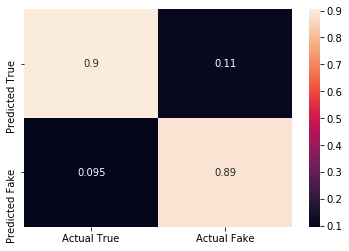

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.title)
X_train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, df_train.target)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(df_train.title, df_train.target)

import numpy as np
predicted = text_clf.predict(df_test.title)
print(np.mean(predicted == df_test.target))

# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted

C = confusion_matrix(y_true, y_pred)
print(C)
# Normalize confusion matrix along actual values
B = C / C.astype(np.float).sum(axis=1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = B
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Normalize confusion matrix along predicted values
A = C / C.astype(np.float).sum(axis=0)

array = A
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## 2. No manipulations to data

0.9625


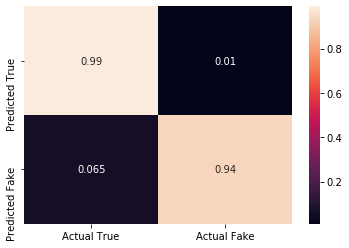

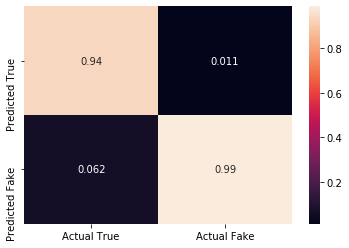

In [230]:
with open("data/real_train.json", "r", encoding="utf8") as file:
    real_train = pd.read_json(file)

with open("data/fake_train.json", "r", encoding="utf8") as file:
    fake_train = pd.read_json(file)

# Add index
# 0 = True, 1 = Fake
real_train["target"] = 0
fake_train["target"] = 1

# Load the test data
with open("data/real_test.json", "r", encoding="utf8") as file:
    real_test = pd.read_json(file)

with open("data/fake_test.json", "r", encoding="utf8") as file:
    fake_test = pd.read_json(file)
    
# Add index
# 0 = True, 1 = Fake
real_test["target"] = 0
fake_test["target"] = 1

# Join data together for real and fake news
df_train = pd.concat([real_train, fake_train])
df_test = pd.concat([real_test, fake_test])

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.text)
X_train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, df_train.target)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(df_train.text, df_train.target)

import numpy as np
predicted = text_clf.predict(df_test.text)
print(np.mean(predicted == df_test.target))

# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted

C = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix along actual values
B = C / C.astype(np.float).sum(axis=1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = B
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Normalize confusion matrix along predicted values
A = C / C.astype(np.float).sum(axis=0)

array = A
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

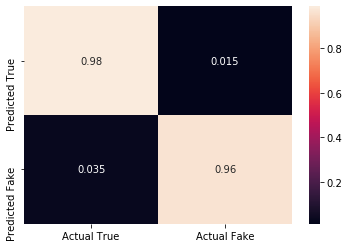

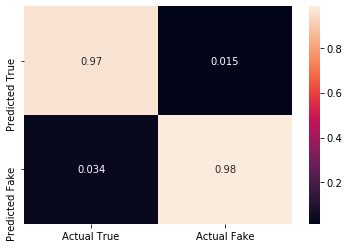

In [231]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42)),]) #n_iter=5
_ = text_clf_svm.fit(df_train.text, df_train.target)
predicted_svm = text_clf_svm.predict(df_test.text)
np.mean(predicted_svm == df_test.target)

# Compute the confusion matrix and plot it
from sklearn.metrics import confusion_matrix
y_true = df_test.target
y_pred = predicted_svm

C = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix along actual values
B = C / C.astype(np.float).sum(axis=1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = B
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Normalize confusion matrix along predicted values
A = C / C.astype(np.float).sum(axis=0)

array = A
df_cm = pd.DataFrame(array, index=["Predicted True", "Predicted Fake"], columns=["Actual True", "Actual Fake"])
plt.figure()#figsize = (10,7))
sn.heatmap(df_cm, annot=True)